## Traininig of the High Level Feature classifier with TensorFlow/Keras

**Tensorflow/Keras, HLF classifier** This notebooks trains a dense neural network for a particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Pandas is used to read the data and pass it to TensorFlow via numpy arrays.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"

## Load train and test datasets via Pandas

In [1]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"


import pandas as pd

testPDF = pd.read_parquet(path= PATH + 'testUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

trainPDF = pd.read_parquet(path= PATH + 'trainUndersampled_HLF_features.parquet', 
                           columns=['HLF_input', 'encoded_label'])

In [2]:
# Check the number of events in the train and test datasets

num_test = testPDF.count()
num_train = trainPDF.count()

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are HLF_input        856090
encoded_label    856090
dtype: int64 events in the test dataset
There are HLF_input        3426083
encoded_label    3426083
dtype: int64 events in the train dataset


In [3]:
# Show the schema and a data sample of the test dataset
testPDF


,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","[1.0, 0.0, 0.0]"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","[1.0, 0.0, 0.0]"
2,"[0.009639073600865505, 0.0010022659022912096, ...","[1.0, 0.0, 0.0]"
3,"[0.016354407625436572, 0.002108937905084598, 0...","[1.0, 0.0, 0.0]"
4,"[0.01925979125354152, 0.004603697276827594, 0....","[1.0, 0.0, 0.0]"
...,...,...
856085,"[0.020383967386165446, 0.0022348975484913444, ...","[0.0, 1.0, 0.0]"
856086,"[0.02475209699743233, 0.00867502196073073, 0.3...","[0.0, 1.0, 0.0]"
856087,"[0.03498179428310887, 0.02506331737284528, 0.9...","[0.0, 1.0, 0.0]"
856088,"[0.03735147362869153, 0.003645269183639405, 0....","[0.0, 1.0, 0.0]"


## Convert training and test datasets from Pandas DataFrames to Numpy arrays

Now we will collect and convert the Pandas DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras.


In [4]:
import numpy as np

X = np.stack(trainPDF["HLF_input"])
y = np.stack(trainPDF["encoded_label"])

X_test = np.stack(testPDF["HLF_input"])
y_test = np.stack(testPDF["encoded_label"])

## Create the Keras model

In [5]:
import tensorflow as tf
tf.__version__

2024-06-11 20:18:42.557581: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 20:18:42.762533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 20:18:46.382238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [6]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

2024-06-11 20:18:49.166736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 20:18:49.311462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 20:18:49.311842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-11 20:18:49.372989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 20:18:49.373359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/

## Train the model

In [8]:
batch_size = 128
n_epochs = 5

%time history = keras_model.fit(X, y, batch_size=batch_size, epochs=n_epochs, \
                                validation_data=(X_test, y_test))


Epoch 1/5


I0000 00:00:1718129932.860451    5556 service.cc:145] XLA service 0x7f8a3c0035e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718129932.860521    5556 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-06-11 20:18:52.903608: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-11 20:18:53.108280: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   82/26767 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.4609 - loss: 1.0649  

I0000 00:00:1718129934.985962    5556 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26767/26767 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.8757 - loss: 0.3330 - val_accuracy: 0.9063 - val_loss: 0.2548
Epoch 2/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9067 - loss: 0.2528 - val_accuracy: 0.9117 - val_loss: 0.2385
Epoch 3/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9110 - loss: 0.2394 - val_accuracy: 0.9134 - val_loss: 0.2342
Epoch 4/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9131 - loss: 0.2342 - val_accuracy: 0.9144 - val_loss: 0.2324
Epoch 5/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9143 - loss: 0.2311 - val_accuracy: 0.9156 - val_loss: 0.2278
CPU times: user 6min 9s, sys: 1min 50s, total: 8min
Wall time: 5min 17s


## Performance metrics

<IPython.core.display.Javascript object>


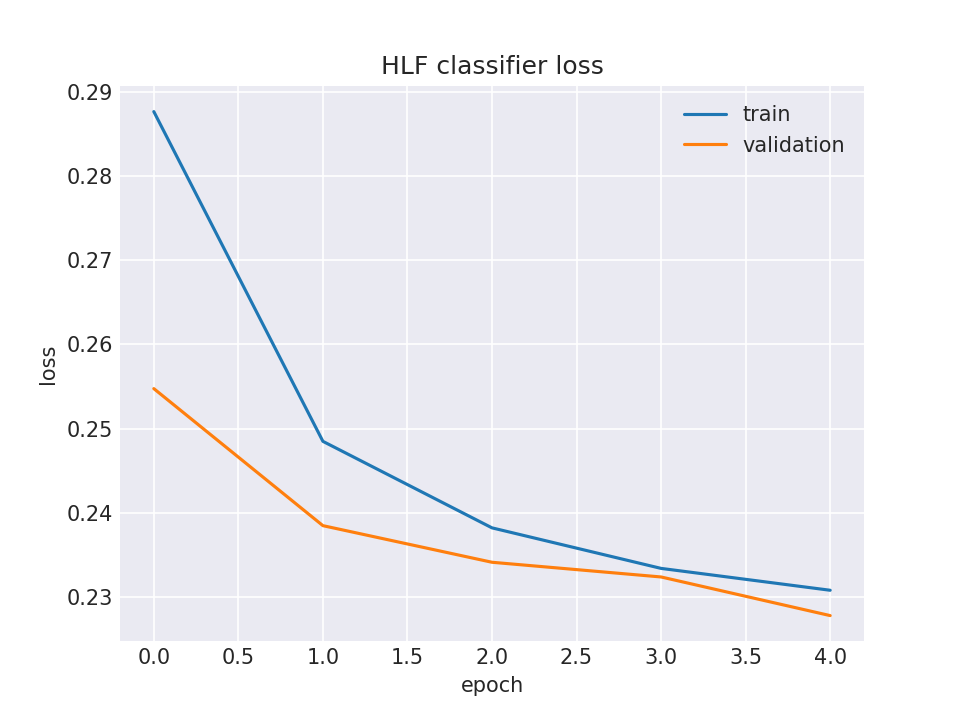

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


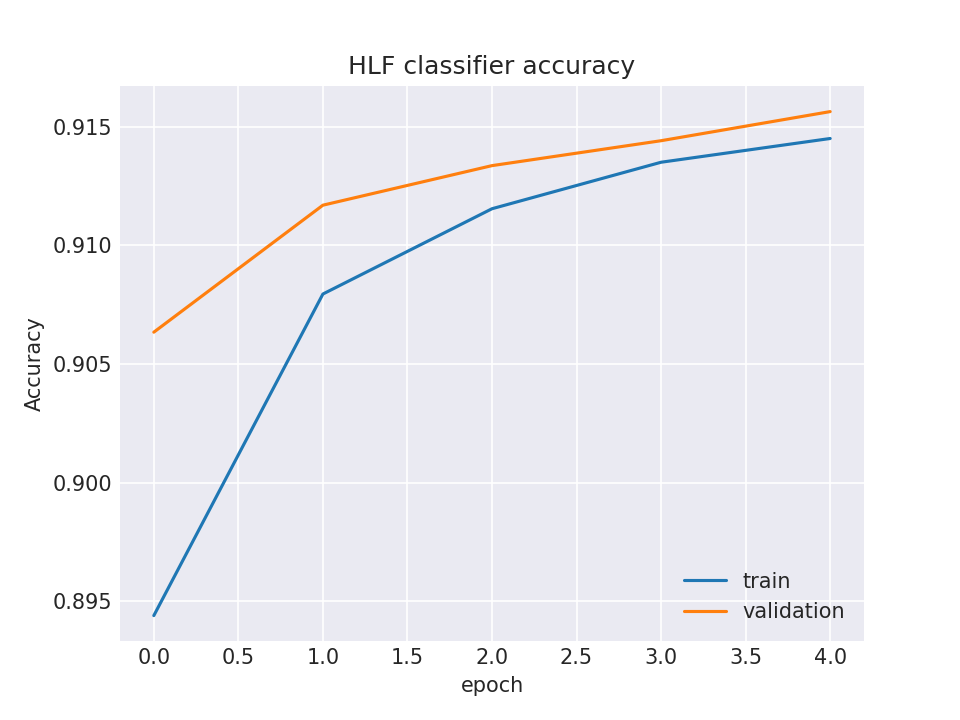

In [10]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [11]:
y_pred=history.model.predict(X_test)
y_true=y_test

26753/26753 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step


In [12]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9156


<IPython.core.display.Javascript object>


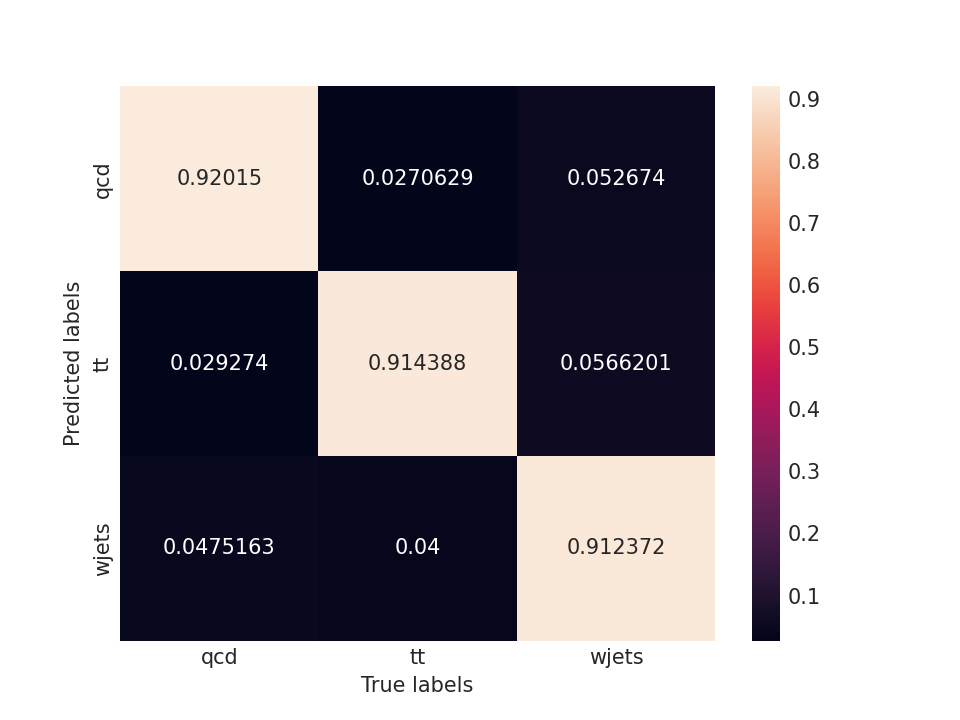

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [14]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [15]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.98740771210857, 1: 0.9854809052110163, 2: 0.9812919906771842}

<IPython.core.display.Javascript object>


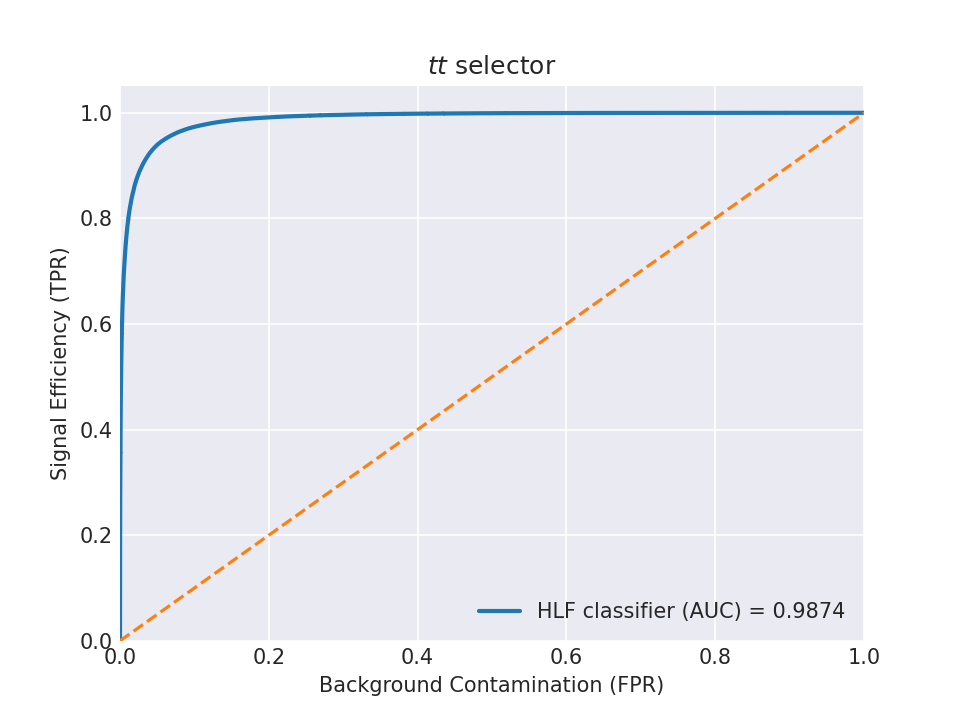

In [16]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()